In [3]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

In [45]:
from IPython.display import display, clear_output
import random
class DynamicMazeTreasureHunt(gym.Env):
    def __init__(self, safe_toggle_ice=True):
        super(DynamicMazeTreasureHunt, self).__init__()

        # Define action and observation spaces, gym.space objects

        self.action_space = spaces.Discrete(4)

        #assuming each robot's field of view can contain up to 10 objects
        # each object is represented by a tuple (object_type, distance, angle)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,shape = (10,3)) # this will change

        # Initialize state
        self.grid_size = (11,12)
        self.grid = np.zeros(self.grid_size)
        self.robot_position = (0,6)
        self.goal_position = [(10,11)]
        self.water_positions = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3), (2,0), (2,1), (2,2), (2,3),
                                (1,5), (1,7), (1,9), (1,10), (2,10), (3,4), (3,8), (3,10),
                                (4,6), (4,7), (4,8), (5,5), (5,9), (5,11), (6,2), (6,3), (6,4), (6,5), (6,9),
                                (10,0), (10,1), (10,2), (10,3), (10,4), (10,5), (10,6), (10,7), (10,8), (10,9), (10,10), (10,11)]
        
        #toggle special ice tile
        if safe_toggle_ice == False:
            print("unsafe ice")
            self.water_positions.append((8,2))


        #initialize rewards
        self.goal_reward = 500
        self.water_reward = -100
        self.living_cost_reward = -1

    def step(self, action):
        # Execute one time step within the environment

        # update robot position based on action
        self.move_robot(action, 0.2)

        terminated = False
        # check for treasure
        if self.robot_position in self.goal_position:
            reward = self.goal_reward
            terminated = True
        elif self.robot_position in self.water_positions:
            reward = self.water_reward
            terminated = True
        else:
            reward = self.living_cost_reward

        #update obersvation
        observation = self.get_observation()


        info = {}

        return observation, reward, terminated, info
    
    def reset(self, random_start=False):
        # Reset the state of the environment to an initial state
        if random_start:
            valid_positions = [(x, y) for x in range(self.grid_size[0]) for y in range(self.grid_size[1]) if (x, y) not in self.water_positions and (x, y) not in self.goal_position]
            self.robot_position = random.choice(valid_positions)
        else:
            self.robot_position = (0, 4)


        return self.get_observation()

    
    from IPython.display import display, clear_output

    def render(self, mode='human'):
        print(self.water_positions)
        if mode == 'human':
            clear_output(wait=True)  # Clear the previous image
            img = np.full((self.grid_size[0], self.grid_size[1], 3), 255, dtype=np.uint8)

            # Assign colors: RGB tuples
            robot_color = [255, 0, 0]  # Red for the robot
            goal_color = [0, 255, 0]  # Green for the goal
            water_color = [0, 0, 255]  # Blue for the water

            # Set the colors
            img[self.robot_position] = robot_color
            for pos in self.goal_position:
                img[pos] = goal_color
            for pos in self.water_positions:
                img[pos] = water_color

            plt.imshow(img)  # Create an image from the RGB array
            plt.show()  # Display the image
            display(plt.gcf())  # Display the current figure       

    def get_observation(self):
        #position gets flattened to one dimension, 11 columns and 10 rows
        return (self.robot_position[0] * 12 + self.robot_position[1])
    
    def move_robot(self, action, slipperiness):
        # update robot position based on action
        if random.random() < slipperiness:
            directions = [0, 1, 2, 3]  # All possible directions
            directions.remove(action)  # Remove the chosen action
            random_direction = random.choice(directions)  # Randomly choose a direction
            action = random_direction  # Update the action

        if action == 0:  # up
            self.robot_position = (max(0, self.robot_position[0]-1), self.robot_position[1])
        elif action == 1:  # down
            self.robot_position = (min(self.grid_size[0]-1, self.robot_position[0]+1), self.robot_position[1])
        elif action == 2:  # left
            self.robot_position = (self.robot_position[0], max(0, self.robot_position[1]-1))
        elif action == 3:  # right
            self.robot_position = (self.robot_position[0], min(self.grid_size[1]-1, self.robot_position[1]+1))

In [5]:
class Agent:
    def __init__(self, state_space_n, action_space_n, gamma=0.9, q_table_file=False):
        self.q_table = np.zeros((state_space_n, action_space_n))
        if q_table_file != False:
            self.load_q_table(q_table_file)
        self.action_space_n = action_space_n
        self.gamma = gamma
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01
        self.learning_rate = 0.1

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_space_n)
        else:
            return np.argmax(self.q_table[state])
        
    def choose_action_no_exploration(self, state):
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state, done):
        #print(state)
        #print(action)
        #print(self.q_table[state, action])
        old_value = self.q_table[state, action]
        next_max = np.max(self.q_table[next_state])

        # Q-learning update rule
        new_value = (1 - self.learning_rate) * old_value + self.learning_rate * (reward + self.gamma * next_max)
        self.q_table[state, action] = new_value

        # Decrease epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def save_q_table(self, file_name):
        np.save(file_name, self.q_table)

    def load_q_table(self, file_name):
        try:
            self.q_table = np.load(file_name)
        except FileNotFoundError:
            print(f"No Q-table file found at {file_name}")

#exploration helpers

In [6]:
def train(agent, environment, episodes, max_steps_per_episode, random_reset = False):
    for episode in range(episodes):
        state = environment.reset(random_start=random_reset)
        total_reward = 0
        done = False

        for step in range(max_steps_per_episode):
            action = agent.choose_action(state)
            next_state, reward, done, _ = environment.step(action)
            agent.learn(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            #environment.render()

            if done:
                break

        #agent.log_performance(episode, total_reward, step)

        # save the Q-table at regular intervals
        if episode % 1000 == 0:
            agent.save_q_table('q_table.npy')
            print(episode)

    # save the final Q-table
    agent.save_q_table('final_q_table.npy')



In [47]:
# Initialize the environment        
env = DynamicMazeTreasureHunt(safe_toggle_ice=False)

# Initialize the agent
agent = Agent(132, 4)

# Train the agent
episodes = 10000
epsilon_decay = 0.99
train(agent, env, episodes, 100, random_reset=True)

unsafe ice
0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [48]:
#test the model

def run_model(agent, environment, episodes, max_steps_per_episode):
    total_reward = 0
    for episode in range(episodes):
        state = environment.reset()
        done = False

        for step in range(max_steps_per_episode):
            action = agent.choose_action_no_exploration(state)
            next_state, reward, done, _ = environment.step(action)

            state = next_state
            total_reward += reward

            environment.render()

            if done:
                break

    print(total_reward)

# Initialize the environment        
env = DynamicMazeTreasureHunt()

# Initialize the agent
agent = Agent(132, 4, 0.9, 'final_q_table.npy')

# Run the agent
episodes = 1000
run_model(agent, env, episodes, 100)

KeyboardInterrupt: 

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

class PolicyVisualizer:
    def __init__(self, q_table_file):
        self.q_table = np.load(q_table_file)

    def visualize(self, environment):
        clear_output(wait=True)  # Clear the previous image
        img = np.full((environment.grid_size[0], environment.grid_size[1], 3), 255, dtype=np.uint8)

        # Assign colors: RGB tuples
        robot_color = [255, 0, 0]  # Red for the robot
        goal_color = [0, 255, 0]  # Green for the goal
        water_color = [0, 0, 255]  # Blue for the water

        # Set the colors
        img[environment.robot_position] = robot_color
        for pos in environment.goal_position:
            img[pos] = goal_color
        for pos in environment.water_positions:
            img[pos] = water_color

        plt.imshow(img)  # Create an image from the RGB array

        # Create a colormap
        cmap = cm.get_cmap('RdYlGn')  # Red to Yellow to Green
        norm = mcolors.Normalize(vmin=-100, vmax=100)  # Assuming reward values range from -1 to 1

        for i in range(environment.grid_size[0]):
            for j in range(environment.grid_size[1]):
                if (i, j) not in environment.goal_position and (i, j) not in environment.water_positions:
                    cell = (i, j)
                    # Draw a diagonal line through a cell
                    plt.plot([cell[1] - 0.5, cell[1] + 0.5], [cell[0] - 0.5, cell[0] + 0.5], color='k', linestyle='-', linewidth=1)
                    plt.plot([cell[1] + 0.5, cell[1] - 0.5], [cell[0] - 0.5, cell[0] + 0.5], color='k', linestyle='-', linewidth=1)

                    # Fill the four triangles
                    q_table_position = i*12 + j
                    rewards = self.q_table[q_table_position]

                    plt.fill([cell[1] - 0.5, cell[1], cell[1] + 0.5], [cell[0] + 0.5, cell[0], cell[0] + 0.5], color=cmap(norm(rewards[1])))  # Top triangle
                    plt.fill([cell[1] - 0.5, cell[1], cell[1] + 0.5], [cell[0] - 0.5, cell[0], cell[0] - 0.5], color=cmap(norm(rewards[0])))  # Bottom triangle
                    plt.fill([cell[1] - 0.5, cell[1] - 0.5, cell[1]], [cell[0] - 0.5, cell[0] + 0.5, cell[0]], color=cmap(norm(rewards[2])))  # Left triangle
                    plt.fill([cell[1] + 0.5, cell[1] + 0.5, cell[1]], [cell[0] - 0.5, cell[0] + 0.5, cell[0]], color=cmap(norm(rewards[3])))  # Right triangle

                    # Display the expected rewards
                    plt.text(cell[1], cell[0] + 0.25, f'{rewards[1]:.2f}', ha='center', va='center', fontsize=8)  # Top triangle
                    plt.text(cell[1], cell[0] - 0.25, f'{rewards[0]:.2f}', ha='center', va='center', fontsize=8)  # Bottom triangle
                    plt.text(cell[1] - 0.25, cell[0], f'{rewards[2]:.2f}', ha='center', va='center', fontsize=8)  # Left triangle
                    plt.text(cell[1] + 0.25, cell[0], f'{rewards[3]:.2f}', ha='center', va='center', fontsize=8)  # Right triangle
                    
        # Add vertical lines
        for i in range(environment.grid_size[1]):
            plt.axvline(x=i + 0.5, color='k', linestyle='-', linewidth=1)

        # Add horizontal lines
        for i in range(environment.grid_size[0]):
            plt.axhline(y=i + 0.5, color='k', linestyle='-', linewidth=1)

        plt.show()  # Display the image
        display(plt.gcf())  # Display the current figure


C:\Users\Andy\AppData\Local\Temp\ipykernel_21568\2900829117.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn')  # Red to Yellow to Green


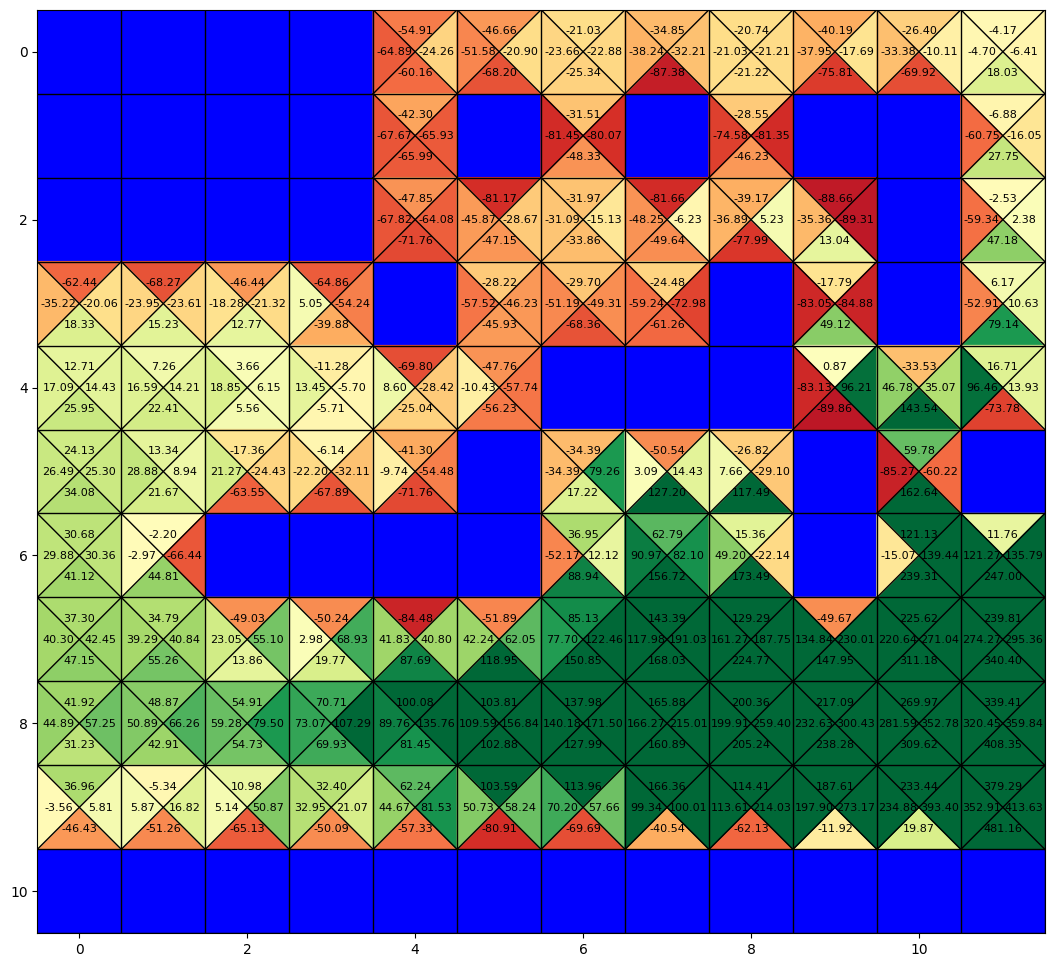

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [36]:
# Create an instance of the PolicyVisualizer
visualizer = PolicyVisualizer('final_q_table.npy')

plt.figure(figsize=(13, 13))

# Call the visualize() method to display the Q-table
visualizer.visualize(env)

